In [39]:
import csv
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, \
    GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

raw_train_df = pd.read_csv('Data/fake_or_real_news_training.csv')
raw_test_df = pd.read_csv('Data/fake_or_real_news_test.csv')

raw_train_df.head()


,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


# Data Exploration and Preparation

In [40]:
raw_train_df.shape

(3999, 6)

In [41]:
raw_test_df.shape

(2321, 3)

In [42]:
raw_test_df.head()

,ID,title,text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...


In [43]:
prepared_train_df = raw_train_df.copy()
prepared_test_df = raw_test_df.copy()

From the below output, two main conclusions can be drawn:
1. X1 and X2 are populated in a very small minority of cases
2. There are rows that are improperly formatted as there should be only 2 unique values for the label

In [44]:
prepared_train_df.nunique()

ID       3999
title    3968
text     3839
label      35
X1          4
X2          2
dtype: int64

In [45]:
#Calculate % of rows that have correct label values
((prepared_train_df['label'].values == 'FAKE').sum() 
 + (prepared_train_df['label'].values == 'REAL').sum())/len(prepared_train_df)


0.991747936984246

Based on the above calculation, the vast majority of rows have the proper format for label and therefore rows that do not conform will be dropped.

In [46]:
#Exclude rows that are in an improper format
prepared_train_df = prepared_train_df[(prepared_train_df['label'] == 'FAKE') | (
    prepared_train_df['label'] == 'REAL')]

prepared_train_df.head()


,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


In [47]:
prepared_train_df.shape

(3966, 6)

As the two labels appear to be very well balanced, no special sampling techniques are necessary.

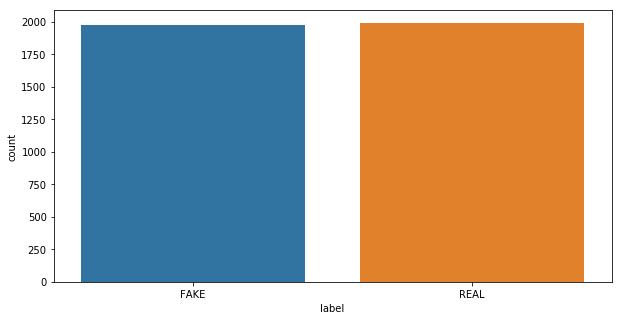

In [48]:
plt.figure(figsize=(10,5)) 
sns.countplot(prepared_train_df['label'])
plt.show()

# Baseline Modeling

The following helper functions were created for easier deployment and comparisons of different tokenization methodologies, models, and feature engineering that will be used later in this analysis. The use of pipelines allows for clean, reusable combinations of the different implementations that will be tested.

In [49]:
def score_model(df, model, vectorizer, target_var, independent_var,
                size, seed, standalone=False, return_model=True):
    df_new = df.copy()

    X = df_new.loc[:, independent_var]
    y = df_new.loc[:, target_var]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=size, random_state=seed)

    #Toggle if pipeline or discrete model is passed
    if(standalone):
        pipeline = model.fit(X=X_train, y=y_train)
    else:
        pipeline = make_pipeline(vectorizer, model).fit(X=X_train, y=y_train)

    pred = pipeline.predict(X_test)

    #Toggle to include model in output
    if(return_model):
        return(pipeline.score(X_test, y_test), y_test, pred, pipeline)
    else:
        return(pipeline.score(X_test, y_test), y_test, pred)


def cv_evaluate(df, model, vectorizer, target_var, independent_var, seed, cv=5,
                standalone=False, metric='accuracy'):
    df_new = df.copy()
    kfolds = KFold(n_splits=cv, shuffle=True, random_state=seed)

    X = df_new.loc[:, independent_var]
    y = df_new.loc[:, target_var]

    #Toggle if pipeline or discrete model is passed
    if(standalone):
        benchmark_model = make_pipeline(
            vectorizer, model).fit(X=X, y=y.values.ravel())
    else:
        benchmark_model = make_pipeline(model).fit(X=X, y=y.values.ravel())

    scores = cross_val_score(benchmark_model, X, y.values.ravel(),
                             scoring=metric, cv=kfolds)
    return scores[scores >= 0.0]


def tune_model(df, model, vectorizer, param, target_var, independent_var,
               seed, cv=5, n_jobs=-1, gridSearch=False, verbose=True, metric='accuracy'):
    df_new = df.copy()
    kfolds = KFold(n_splits=cv, shuffle=True, random_state=seed)

    X = df_new.loc[:, independent_var]
    y = df_new.loc[:, target_var]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=size, random_state=seed)
    pipeline = Pipeline([vectorizer, model])

    #Toggle to run Grid Search or Randomized Search (to save on computation time)
    if(gridSearch):
        gsearch = GridSearchCV(estimator=pipeline, param_grid=param,
                               scoring=metric, n_jobs=n_jobs, cv=kfolds, verbose=verbose)
    else:
        gsearch = RandomizedSearchCV(estimator=pipeline, param_distributions=param,
                                     scoring=metric, n_jobs=n_jobs, cv=kfolds, verbose=verbose)

    gsearch.fit(X_train, y_train)
    tuned_model = gsearch.best_estimator_

    if(verbose):
        print('='*20)
        print("best params: " + str(gsearch.best_estimator_))
        print("best params: " + str(gsearch.best_params_))
        print('best score:', gsearch.best_score_)
        print('='*20)

    return tuned_model


def confusion_heat_map(test_set, prediction_set, class_names):
    cm = confusion_matrix(test_set, prediction_set, class_names)
    fig, ax = plt.subplots()

    # create heatmap
    g = sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='g',
                    xticklabels=True, yticklabels=True)
    ax.xaxis.set_label_position("top")
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.title('Confusion matrix', y=1.1)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def run_full_iteration(df, model, vectorizer, target_var, independent_var, size,
                       seed, standalone=False, return_model=True, cv=5):
    #Returns score on holdout set
    score, y_test, pred, model = score_model(
        df, model, vectorizer, target_var, independent_var, size,
        seed, standalone, return_model)
    print("Accuracy: %0.3f" % score)

    #Returns cross-validated score
    accuracy = cv_evaluate(df, model, vectorizer,
                           target_var, independent_var, seed, cv)
    print('Mean Accuracy after CV: {:.3f} +/- {:.03f}'.format(np.mean(accuracy), np.std(accuracy)))
    print('Best Accuracy after CV: {:.3f}'.format(max(accuracy)))

    confusion_heat_map(y_test, pred, ['FAKE', 'REAL'])


def csv_conversion(df, y, id_field, old_target_name):
    # Merge prediction with original data set to map with id
    raw_output = df.join(y)
    clean_output = raw_output.loc[:, [id_field, 0]]
    clean_output.columns = [id_field, old_target_name]
    return clean_output


## Count Vectorizer

The count vectorizor function simply tokenizes a set of text and counts the appearence frequency of words. As can be seen from the below results, this simplistic methodology already yields decent results. 

In [50]:
# Set test set size, seed and target metric for the rest of the pipeline
size = 0.20
seed = 12345
target_var = 'label'
independent_var = 'text'

models = []
models.append(('MNB', MultinomialNB()))
# models.append(('LR', LogisticRegression(solver='lbfgs', multi_class='auto'))) #Fails to converge
# models.append(('KNN', KNeighborsClassifier())) #very poor performance
models.append(('RFC', RandomForestClassifier(random_state = seed)))
models.append(('SVM', SVC(kernel='linear')))
models.append(('PAC', PassiveAggressiveClassifier(random_state=seed)))
# models.append(('GB', GradientBoostingClassifier())) #takes too long

vectorizer = CountVectorizer(stop_words='english')

# evaluate each model in turn
results = []
names = []
for name, model in models:
    cv_results = cv_evaluate(prepared_train_df, model,
                             vectorizer, target_var, 
                             independent_var, seed, cv=4, standalone=True)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


MNB: 0.883260 (0.006183)
RFC: 0.827531 (0.015748)
SVM: 0.858796 (0.013468)
PAC: 0.881748 (0.015011)


## Hashing Vectorizer

The hashing vectorizer is a more memory efficient tokenization/count implementation than the regular count vectorizer. An improvement in score can be seen, however this is still a fairly simplistic implemntation.

In [51]:
vectorizer = HashingVectorizer(stop_words='english', non_negative=True)

# evaluate each model in turn
results = []
names = []
for name, model in models:
    cv_results = cv_evaluate(prepared_train_df, model,
                             vectorizer, target_var, 
                             independent_var, seed, cv=4, standalone=True)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

MNB: 0.790984 (0.028493)
RFC: 0.788955 (0.004739)
SVM: 0.913772 (0.010858)
PAC: 0.915284 (0.013372)


## Tfid Vectorizer

On the otherhand TfidfVectorizer does everything the count vectorizer does, but also transforms the counts into TF/IDF values. This is crucially different as rather relying on the pure count of a word to denote its importance, words that are seen in multiple documents with great frequency are given less weight (e.g. "the", "is", etc.). Using this methodology, a material improvement in prediction accuracy is ade accross all models.

In [12]:
models = []
models.append(('MNB', MultinomialNB()))
models.append(('LR', LogisticRegression(solver='lbfgs', multi_class='auto')))
# models.append(('KNN', KNeighborsClassifier())) #very poor performance
models.append(('RFC', RandomForestClassifier(random_state=seed)))
models.append(('SVM', SVC(kernel='linear')))
models.append(('PAC', PassiveAggressiveClassifier(random_state=seed)))
# models.append(('GB', GradientBoostingClassifier())) #takes too long

vectorizer = TfidfVectorizer(stop_words='english')

# evaluate each model in turn
results = []
names = []
for name, model in models:
    cv_results = cv_evaluate(prepared_train_df, model,
                             vectorizer, target_var, 
                             independent_var, seed, cv=4, standalone=True)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


MNB: 0.812418 (0.027469)
LR: 0.903180 (0.007200)
RFC: 0.836861 (0.010552)
SVM: 0.925873 (0.009685)
PAC: 0.926629 (0.010825)


## Full Analysis of Best Baseline Model

Based on the above results, it is clear that the winning combination is the Passive Aggressive Classifier (PAC) algorithm using Tfid Vectorizor. Put very simply, the PAC is "passive" in the sense that while in training, if it correctly classifies a particular instance, it does nothing and "aggressive" as it will update with incorrect classifications. It is particuarly well suited for large sets of data (Lavrenko 2014 https://bit.ly/2VUcBpk).

It can be seen below that the high accuracy holds even with cross validation.

Accuracy: 0.912
Mean Accuracy after CV: 0.928 +/- 0.011
Best Accuracy after CV: 0.946


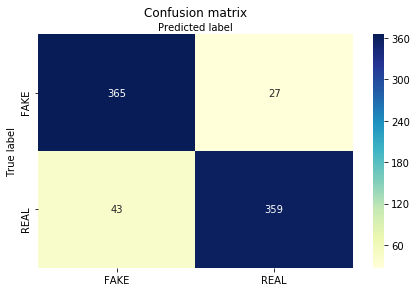

In [53]:
model = PassiveAggressiveClassifier(random_state=seed)

run_full_iteration(prepared_train_df, model, vectorizer,
                   target_var, independent_var, size, seed)


# Feature Engineering

## FE1: Combine Title and Text

In [54]:
fe1_train_df = prepared_train_df.copy()
fe1_test_df = prepared_test_df.copy()

fe1_train_df['combined'] = fe1_train_df['title'] + fe1_train_df['text']
fe1_test_df['combined'] = fe1_test_df['title'] + fe1_test_df['text']
fe1_train_df.head()

,ID,title,text,label,X1,X2,combined
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN,"You Can Smell Hillary’s FearDaniel Greenfield,..."
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN,Watch The Exact Moment Paul Ryan Committed Pol...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN,Kerry to go to Paris in gesture of sympathyU.S...
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN,Bernie supporters on Twitter erupt in anger ag...
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN,The Battle of New York: Why This Primary Matte...


Accuracy: 0.918
Mean Accuracy after CV: 0.929 +/- 0.011
Best Accuracy after CV: 0.945


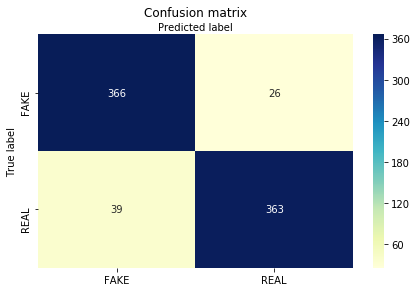

In [55]:
independent_var = 'combined'
run_full_iteration(fe1_train_df, model, vectorizer,
                   target_var, independent_var, size, seed)


# Hyperparameter Tuning

In [ ]:
param = {
    'tfidf__max_df': (0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'PAC__C': [0.1, 1, 10]
}

vectorizer_object = ('tfidf', vectorizer)
model_object = ('PAC', model)

tuned_model = tune_model(fe1_train_df, model_object, vectorizer_object, param, target_var, independent_var,
                         seed, gridSearch=True)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
run_full_iteration(fe1_train_df, tuned_model, vectorizer,
                   target_var, independent_var, size, seed, standalone=True)


# Predict on Test Set

In [ ]:
final_pred = pd.DataFrame(tuned_model.predict(fe1_test_df['combined']))
final_clean_output = csv_conversion(fe1_test_df, final_pred, 
                                    id_field = 'ID',old_target_name=target_var)

final_clean_output.to_csv("NLP_FAKE_NEWS_PREDICTIONS.csv", index=False)
final_clean_output.head()
